### Denoising Diffusion Probabilistic Models

Let's build our own DDPM now:

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [3]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

The `Unet` model we are about to import from huggingface's `diffusers` library takes in `32x32` images, so for ease we can change the size of the Fashion-MNIST images to `32x32`:

In [4]:
@inplace
def transformi(b): b[x] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[x]]

In [5]:
set_seed(1)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

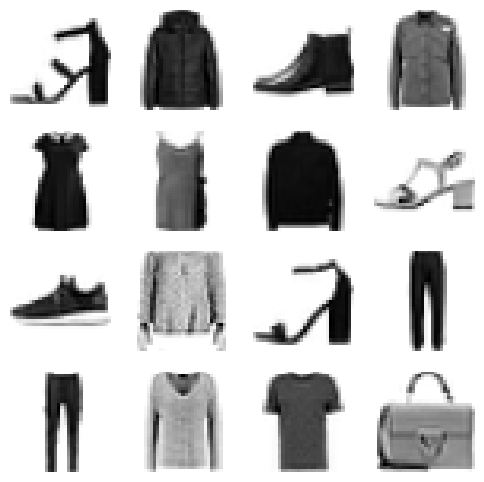

In [6]:
show_images(-xb[:16], imsize=1.5)

In [7]:
from diffusers import UNet2DModel

In [8]:
class DDPMCB(TrainCB_old):
    order = DeviceCB.order+1
    def __init__(self, n_steps, beta_min, beta_max):
        self.n_steps,self.βmin,self.βmax = n_steps,beta_min,beta_max
        # variance schedule, linearly increased with timestep
        self.β = torch.linspace(self.βmin, self.βmax, self.n_steps)
        self.α = 1. - self.β 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.β.sqrt()

    def predict(self, learn): learn.preds = learn.model(*learn.batch[0]).sample
    
    def before_batch(self, learn):
        device = learn.batch[0].device
        ε = torch.randn(learn.batch[0].shape, device=device)  # noise, x_T
        x0 = learn.batch[0] # original images, x_0
        self.ᾱ = self.ᾱ.to(device)
        n = x0.shape[0]
        # select random timesteps
        t = torch.randint(0, self.n_steps, (n,), device=device, dtype=torch.long)
        ᾱ_t = self.ᾱ[t].reshape(-1, 1, 1, 1).to(device)
        xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε #noisify the image
        # input to our model is noisy image and timestep, ground truth is the noise 
        learn.batch = ((xt, t), ε)
    
    @torch.no_grad()
    def sample(self, model, sz):
        device = next(model.parameters()).device
        x_t = torch.randn(sz, device=device)
        preds = []
        for t in reversed(range(self.n_steps)):
            t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
            z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
            ᾱ_t1 = self.ᾱ[t-1]  if t > 0 else torch.tensor(1)
            b̄_t = 1 - self.ᾱ[t]
            b̄_t1 = 1 - ᾱ_t1
            noise_pred = learn.model(x_t, t_batch).sample
            x_0_hat = ((x_t - b̄_t.sqrt() * noise_pred)/self.ᾱ[t].sqrt()).clamp(-1,1)
            x0_coeff = ᾱ_t1.sqrt()*(1-self.α[t])/b̄_t
            xt_coeff = self.α[t].sqrt()*b̄_t1/b̄_t
            x_t = x_0_hat*x0_coeff + x_t*xt_coeff + self.σ[t]*z
            preds.append(x_t.cpu())
        return preds

In [57]:
Learner??

In [174]:
TrainCB_old??

In [177]:
TrainCB??

In [176]:
BatchSchedCB??

In [55]:
BaseSchedCB??

In [61]:
TrainLearner??

In [9]:
class BaseSchedCB(Callback):
    def __init__(self, sched): 
        self.sched = sched
        self.i = 0
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def step(self, learn):
        print(self.i)
        if learn.training and not self.done:
            self.schedo.step()
            self.done = True
            self.i += 1
            print(self.i)
            print(self.done)

In [10]:
class BatchSchedCB(BaseSchedCB):
    def before_batch(self, learn): 
        self.done = False
        print(self.done)
    def after_batch(self, learn):
#         import pdb; pdb.set_trace()
        self.step(learn)

In [11]:
lr_scheduler.OneCycleLR.step

<function torch.optim.lr_scheduler._LRScheduler.step(self, epoch=None)>

In [12]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 128))

In [133]:
SingleBatchCB??

In [13]:
lr = 3e-3
epochs = 1
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
# cbs = [ddpm_cb, DeviceCB(), SingleBatchCB(), MetricsCB(), BatchSchedCB(sched)]
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=optim.Adam)

False
0
1
True
1


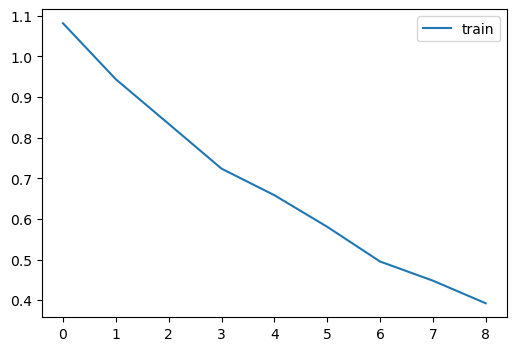

False
1
2
True
2
False
2
3
True
3
False
3
4
True
4
False
4
5
True
5
False
5
6
True
6
False
6
7
True
7
False
7
8
True
8
False
8
9
True
9
False
9
10
True


KeyboardInterrupt: 

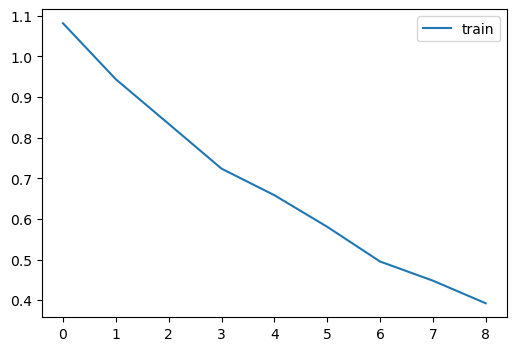

In [173]:
learn.fit(epochs)

In [116]:
cbs[-1].i

1

In [109]:
learn.

TypeError: 'UNet2DModel' object is not iterable

In [38]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)

In [39]:
torch.save(learn.model, mdl_path/'fashion_ddpm.pkl')

In [40]:
learn.model = torch.load(mdl_path/'fashion_ddpm.pkl')

In [16]:
set_seed(1)
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))
len(samples)

1000

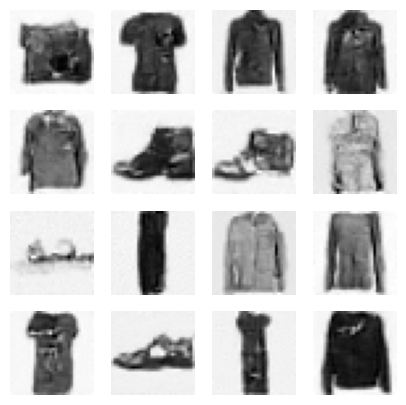

In [17]:
show_images(-samples[-1], figsize=(5,5))

In [121]:
clean_mem()